In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory  # pip install tf-nightly
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
tf.debugging.set_log_device_placement(False)  # don't show device log
print("Num GPUs Available: ",
      len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
DATASET_DIR = "./augment_dataset/sdd"

TRAIN_DATASET_DIR = DATASET_DIR + '/train'

TEST_DATASET_DIR = DATASET_DIR + '/test'

IMG_SIZE = (32, 32)

BATCH_SIZE = 128

In [4]:
# build train dataset
train_ds = image_dataset_from_directory(directory=TRAIN_DATASET_DIR,
                                        labels='inferred',
                                        label_mode='categorical',
                                        shuffle=True,
                                        batch_size=BATCH_SIZE,
                                        image_size=IMG_SIZE)

#build test dataset
test_ds = image_dataset_from_directory(directory=TEST_DATASET_DIR,
                                       labels='inferred',
                                       label_mode='categorical',
                                       shuffle=False,
                                       batch_size=BATCH_SIZE,
                                       image_size=IMG_SIZE)

Found 32458 files belonging to 120 classes.
Found 8222 files belonging to 120 classes.


train_imgs.shape:  (128, 32, 32, 3)
train_labels.shape:  (128, 120)
['n02100236-German_short-haired_pointer', 'n02093256-Staffordshire_bullterrier', 'n02090721-Irish_wolfhound', 'n02099429-curly-coated_retriever', 'n02093991-Irish_terrier', 'n02110806-basenji', 'n02095570-Lakeland_terrier', 'n02094258-Norwich_terrier', 'n02093647-Bedlington_terrier', 'n02112706-Brabancon_griffon', 'n02110063-malamute', 'n02112706-Brabancon_griffon', 'n02111129-Leonberg', 'n02111889-Samoyed', 'n02106166-Border_collie', 'n02112706-Brabancon_griffon', 'n02102040-English_springer', 'n02112137-chow', 'n02112018-Pomeranian', 'n02096294-Australian_terrier', 'n02106030-collie', 'n02093754-Border_terrier', 'n02093754-Border_terrier', 'n02086646-Blenheim_spaniel', 'n02105251-briard', 'n02105641-Old_English_sheepdog', 'n02107683-Bernese_mountain_dog', 'n02097047-miniature_schnauzer', 'n02108000-EntleBucher', 'n02099429-curly-coated_retriever', 'n02090721-Irish_wolfhound', 'n02092002-Scottish_deerhound', 'n0209163

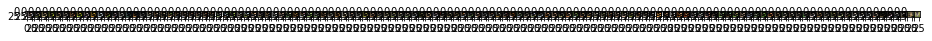

In [5]:
# show train batch
train_imgs, train_labels = next(iter(train_ds))

print("train_imgs.shape: ", train_imgs.shape)
print("train_labels.shape: ", train_labels.shape)

plt.figure(num=BATCH_SIZE, figsize=(16, 16))
for i, img in enumerate(train_imgs):
    plt.subplot(1, BATCH_SIZE, i + 1)
    plt.imshow(tf.make_ndarray(tf.make_tensor_proto(img)).astype('uint8'))

labels = [
    train_ds.class_names[np.where(label == 1)[0][0]] for label in train_labels
]
print(labels)

In [6]:
# show dataset info
print("\ntraing dataset size:", len(train_ds))
print("test dataset size:", len(test_ds))
print("\nclass names:\n", train_ds.class_names)


traing dataset size: 254
test dataset size: 65

class names:
 ['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-Walker_hound', 'n02089973-English_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-Irish_wolfhound', 'n02091032-Italian_greyhound', 'n02091134-whippet', 'n02091244-Ibizan_hound', 'n02091467-Norwegian_elkhound', 'n02091635-otterhound', 'n02091831-Saluki', 'n02092002-Scottish_deerhound', 'n02092339-Weimaraner', 'n02093256-Staffordshire_bullterrier', 'n02093428-American_Staffordshire_terrier', 'n02093647-Bedlington_terrier', 'n02093754-Border_terrier', 'n02093859-Kerry_blue_terrier', 'n02093991-Irish_terrier', 'n02094114-Norfol

In [7]:
class SE_Block(Model):
    def __init__(self, filters):
        super(SE_Block, self).__init__(name='')

        r = 8

        self.global_avg_pool = GlobalAveragePooling2D()

        self.fc1 = Dense(filters / r, activation='relu')

        self.fc2 = Dense(filters, activation='sigmoid')

    def call(self, x):
        c = x.shape[-1]
        inp = x
        x = self.global_avg_pool(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = tf.reshape(x, [-1,1,1,c])
        x *= inp

        return x

In [8]:
class ResBasicBlock(Model):
    def __init__(self, filters, kernel_size, padding='same', strides=1):
        super(ResBasicBlock, self).__init__(name='')

        flt1, flt2, flt3 = filters

        self.conv1 = Conv2D(flt1, 1, padding=padding, strides=strides)
        #             kernel_regularizer=tf.keras.regularizers.l2(l=0.003))

        self.dwcovn1 = SeparableConv2D(flt2, kernel_size, padding=padding)

        self.conv2 = Conv2D(flt3, 1, padding=padding)
        #             kernel_regularizer=tf.keras.regularizers.l2(l=0.003))

        self.reshape_conv = Conv2D(flt3, 1, padding=padding, strides=strides)

        self.bn1 = BatchNormalization()
        self.bn2 = BatchNormalization()
        self.bn3 = BatchNormalization()
        self.bn4 = BatchNormalization()

    def call(self, x):
        inp = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = tf.nn.relu6(x)

        x = self.dwcovn1(x)
        x = self.bn2(x)
        x = tf.nn.relu6(x)

        x = self.conv2(x)
        x = self.bn3(x)

        inp = self.reshape_conv(inp)
        inp = self.bn4(inp)
        x += inp

        x = tf.nn.relu(x)

        return x

In [9]:
class ResBlockA(Model):
    def __init__(self):
        super(ResBlockA, self).__init__(name='')

        filters = (32, 32, 128)

        self.res_blocks = Sequential([])

        for _ in range(3):
            self.res_blocks.add(ResBasicBlock(filters, kernel_size=3))

    def call(self, x):
        x = self.res_blocks(x)

        return x

In [10]:
class ResBlockB(Model):
    def __init__(self):
        super(ResBlockB, self).__init__(name='')

        filters = (64, 64, 256)

        self.res_blocks = Sequential(
            [ResBasicBlock(filters, kernel_size=3, strides=2)])

        for _ in range(3):
            self.res_blocks.add(ResBasicBlock(filters, kernel_size=3))

    def call(self, x):
        x = self.res_blocks(x)

        return x

In [11]:
class ResBlockC(Model):
    def __init__(self):
        super(ResBlockC, self).__init__(name='')

        filters = (128, 128, 512)

        self.res_blocks = Sequential(
            [ResBasicBlock(filters, kernel_size=3, strides=2)])

        for _ in range(5):
            self.res_blocks.add(ResBasicBlock(filters, kernel_size=3))

    def call(self, x):
        x = self.res_blocks(x)

        return x

In [12]:
class ResBlockD(Model):
    def __init__(self):
        super(ResBlockD, self).__init__(name='')

        filters = (512, 512, 1024)

        self.res_blocks = Sequential(
            [ResBasicBlock(filters, kernel_size=3, strides=2)])

        for _ in range(2):
            self.res_blocks.add(ResBasicBlock(filters, kernel_size=3))

    def call(self, x):
        x = self.res_blocks(x)

        return x

In [13]:
class BokuNet(Model):
    def __init__(self):
        super(BokuNet, self).__init__(name='BokuNet')
        self.conv1 = Conv2D(32, 7, strides=2)
        self.max_pool = MaxPooling2D((3, 3), strides=2)

        self.res_bloack_a = ResBlockA()
        self.res_block_b = ResBlockB()
#         self.res_block_c = ResBlockC()
#         self.res_block_d = ResBlockD()

        self.avg_pool = AveragePooling2D()
        self.flatten = Flatten()

        self.out_fc = Dense(120, activation='softmax')


#         self.drop1 = Dropout(0.5)

    def call(self, x):
        x = x / 255  # normalization

        x = self.conv1(x)
#         print(x.shape)
        x = self.max_pool(x)
#         print(x.shape)

        x = self.res_bloack_a(x)
#         print('a', x.shape)

        x = self.res_block_b(x)
#         print('b', x.shape)

#         x = self.res_block_c(x)
#         print('c', x.shape)

#         x = self.res_block_d(x)
#         print('d', x.shape)

        x = self.avg_pool(x)
#         print(x.shape)

        x = self.flatten(x)

        x = self.out_fc(x)

        return x

In [14]:
model = BokuNet()
# model = SE_Block(64)
imgs_shape = (128, 32, 32, 3)
model.build(imgs_shape)
print(model.summary())

Model: "BokuNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  4736      
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
res_block_a (ResBlockA)      multiple                  67104     
_________________________________________________________________
res_block_b (ResBlockB)      multiple                  383744    
_________________________________________________________________
average_pooling2d (AveragePo multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  3084

In [15]:
EPOCHS = 15

checkpoint_path = "checkpoint/cp.ckpt"

if os.path.isfile(checkpoint_path):
    model.load_weights(checkpoint_path)

cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                              save_weights_only=True,
                              verbose=1)

optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds,
                    batch_size=BATCH_SIZE,
                    steps_per_epoch=len(train_ds),
                    validation_data=test_ds,
                    validation_steps=len(test_ds),
                    epochs=EPOCHS,
                    callbacks=[cp_callback])

Epoch 1/15
254/254 [==============================] - ETA: 0s - loss: 4.6298 - accuracy: 0.0269
Epoch 00001: saving model to checkpoint\cp.ckpt
254/254 [==============================] - 85s 335ms/step - loss: 4.6298 - accuracy: 0.0269 - val_loss: 5.1538 - val_accuracy: 0.0084
Epoch 2/15
254/254 [==============================] - ETA: 0s - loss: 4.3026 - accuracy: 0.0550
Epoch 00002: saving model to checkpoint\cp.ckpt
254/254 [==============================] - 85s 335ms/step - loss: 4.3026 - accuracy: 0.0550 - val_loss: 4.4866 - val_accuracy: 0.0396
Epoch 3/15
254/254 [==============================] - ETA: 0s - loss: 4.1255 - accuracy: 0.0772
Epoch 00003: saving model to checkpoint\cp.ckpt
254/254 [==============================] - 86s 337ms/step - loss: 4.1255 - accuracy: 0.0772 - val_loss: 4.5256 - val_accuracy: 0.0483
Epoch 4/15
254/254 [==============================] - ETA: 0s - loss: 3.9710 - accuracy: 0.0954
Epoch 00004: saving model to checkpoint\cp.ckpt
254/254 [=============

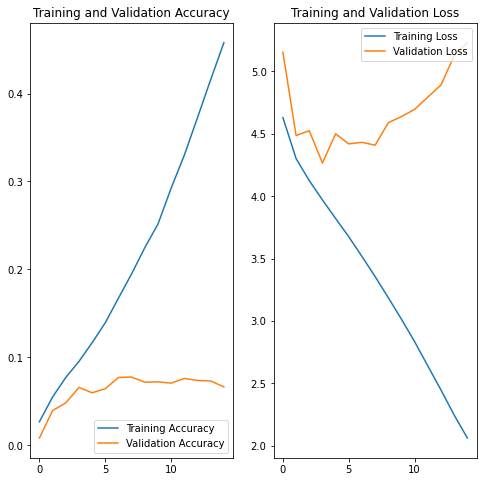

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()